# Programming Assignment 1 - Supervised Learning - Classification

## Dataset 1 - Stroke Prediction Dataset (Kaggle)

Source: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import sklearn

from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, learning_curve, validation_curve, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from imblearn.under_sampling import InstanceHardnessThreshold, CondensedNearestNeighbour
from imblearn.over_sampling import SMOTE

%matplotlib inline

import time

In [2]:
# Common constants
random_seed = 1

SAVE_IMAGES = True

USE_UNDERSAMPLING_IHT = 'USE_UNDERSAMPLING_IHT'
USE_UNDERSAMPLING_CNN = 'USE_UNDERSAMPLING_CNN'
USE_OVERSAMPLING_SMOTE = 'USE_OVERSAMPLING_SMOTE'

DATASET_1 = 'DATASET_1'
DATASET_2 = 'DATASET_2'

# Define variables and lists to run algos/store metrics
fold_size = 10
knn_neighbors = 200
neighbors_range = np.arange(1, knn_neighbors+1)

In [3]:
# Dataset 1 constants
RESAMPLING_TECHNIQUE = USE_UNDERSAMPLING_IHT
DATASET_ID = DATASET_1

In [4]:
## Utility functions

# First column in both the dataset is ID column which serves no purpose in classifiation and does not tells us about the sample. 
# Therefore id column will be removed from data
def getData(id):
    if id == DATASET_1:
        data = pd.read_csv("healthcare-dataset-stroke-data.csv")
    elif id == DATASET_2:
        data = pd.read_csv("BankChurners.csv")
    data = data.iloc[:, 1:]
    return data


def print_metrics(classifier_type:str, y_test, y_pred):
    print(f'Metrics for classifier: {classifier_type}')
    cm = confusion_matrix(y_test, y_pred)
    print(f'Confusion Matrix: \n {cm}')
    print(f'Accuracy score {accuracy_score(y_test, y_pred)}')
    print(f'Precision score {precision_score(y_test, y_pred)}')
    print(f'Recall score {recall_score(y_test, y_pred)}')
    print(f'ROC AUC score {roc_auc_score(y_test, y_pred)}')
    print(f'F1 score {f1_score(y_test, y_pred)}')
    
    
'''
data: dictionary
    x_values, train_scores, test_scores, train_legend, test_legend, title, xlabel, ylabel, figname
'''
def create_plot(data):
    x_values = data.get('x_values')
    train_scores = data.get('train_scores')
    test_scores = data.get('test_scores')
    test_legend = data.get('test_legend')
    train_legend = data.get('train_legend')
    figname = data.get('figname')
    
    plt.figure()
    plt.plot(x_values, train_scores, label=train_legend)
    plt.plot(x_values, test_scores, label=test_legend)
    plt.title(data.get('title'))
    plt.xlabel(data.get('xlabel'))
    plt.ylabel(data.get('ylabel'))
    plt.legend(loc="best")
    plt.grid()
    if figname and SAVE_IMAGES:
        plt.savefig(figname)
    plt.show()
    

def create_curve(x_range=None, train_scores=None, test_scores=None, train_legend='', test_legend='', title='', x_label='', y_label='', figname=''):
    plt.figure()
    plt.plot(x_range, np.mean(train_scores, axis=1), label=train_legend)
    plt.plot(x_range, np.mean(test_scores, axis=1), label=test_legend)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(loc="best")
    plt.grid()
    if figname and SAVE_IMAGES:
        plt.savefig(figname)
    plt.show()
    

def get_correlations(data, dataset_id):
    if dataset_id == DATASET_1:
        return data.corr().stroke.sort_values()
    elif dataset_id == DATASET_2:
        return data.corr()['Attrition_Flag'].sort_values()

    
def do_column_one_hot_encoding(X, col_indices):
    ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), col_indices)], remainder='passthrough')
    # remainder = passthrough means keep other columns on which encoding is not applied, else will get only enoded columns 
    X_encoded = ct.fit_transform(X)

    print(f'First row of X after imputation and encoding: {X_encoded[0]}')
    print(ct.get_feature_names_out())
    return X_encoded


# reference: https://www.udemy.com/course/machine-learning-with-imbalanced-data/

# reference: https://github.com/solegalli/machine-learning-imbalanced-data/blob/master/Section-04-Undersampling/04-10-Instance-Hardness-Threshold.ipynb
rf = RandomForestClassifier(n_estimators=5, random_state=1, max_depth=1)
iht = InstanceHardnessThreshold(
    estimator=rf,
    sampling_strategy=.6,  # undersamples only the majority class
    random_state=random_seed,
    n_jobs=4, # have 4 processors in my laptop
    cv=3,  # cross validation fold
)

# Reference: https://github.com/solegalli/machine-learning-imbalanced-data/blob/master/Section-05-Oversampling/05-03-SMOTE.ipynb
smnc = SMOTE(
    sampling_strategy='auto', # samples only the minority class
    random_state=0,  # for reproducibility
    k_neighbors=5,
    n_jobs=4
)

# Reference: https://github.com/solegalli/machine-learning-imbalanced-data/blob/master/Section-04-Undersampling/04-02-Condensed-Nearest-Neighbours.ipynb
cnn = CondensedNearestNeighbour(
    sampling_strategy='auto',  # undersamples only the majority class
    random_state=0,  # for reproducibility
    n_neighbors=1,# default
    n_jobs=4)  # I have 4 cores in my laptop

def do_resampling(X, y):
    if RESAMPLING_TECHNIQUE == USE_UNDERSAMPLING_IHT:
        X_resampled, y_resampled = iht.fit_resample(X, y)
    elif RESAMPLING_TECHNIQUE == USE_UNDERSAMPLING_CNN:
        X_resampled, y_resampled = cnn.fit_resample(X, y)
    elif RESAMPLING_TECHNIQUE == USE_OVERSAMPLING_SMOTE:
        X_resampled, y_resampled = smnc.fit_resample(X, y)
    else:
        X_resampled, y_resampled = X, y

    print(f'After resampling with {RESAMPLING_TECHNIQUE}: Shape of X: {X_resampled.shape}, Shape of y: {y_resampled.shape}')

    unique, counts = np.unique(y_resampled, return_counts=True)
    print(f'After resampling: value counts: {unique} : {counts}')

    print(X_resampled[0])
    
    return X_resampled, y_resampled

def create_time_plot(title, xlabel, ylabel, knn_times, dt_times, ada_times, svm_times, nn_times, figname=''):
    x_range = np.arange(0.1, 1.0, .1)
    plt.figure()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(x_range, np.sum(nn_times, axis=1), color="orange", label="Neural Networks")
    plt.plot(x_range, np.sum(svm_times, axis=1), color="green", label="SVM")
    plt.plot(x_range, np.sum(knn_times, axis=1), color="red", label="KNN")
    plt.plot(x_range, np.sum(dt_times, axis=1), color="blue", label="Decision Tree")
    plt.plot(x_range, np.sum(ada_times, axis=1), color="lime", label="Adaboost")
    plt.legend(loc="best")
    plt.grid()
    if figname and SAVE_IMAGES:
        plt.savefig(figname)
    plt.show()
    
def create_log_curve(x_range=None, train_scores=None, test_scores=None, train_legend='', test_legend='', 
                     title='', x_label='', y_label='', figname=''):
    plt.figure()
    plt.semilogx(x_range, np.mean(train_scores, axis=1), label=train_legend)
    plt.semilogx(x_range, np.mean(test_scores, axis=1), label=test_legend)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(loc="best")
    plt.grid()
    if figname and SAVE_IMAGES:
        plt.savefig(figname)
    plt.show()
    
def create_loss_curve(scores=None, legend='', title='', x_label='', y_label='', figname=''):
    plt.figure()
    plt.title(title)
    plt.plot(scores, color="blue", label=legend)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(loc="best")
    plt.grid()
    if figname and SAVE_IMAGES:
        plt.savefig(figname)
    plt.show()
    
def get_mean_score(test_scores):
    return np.mean(np.sum(test_scores, axis=1), axis=0)*fold_size

def create_model_comparison(knn_mean, dt_mean, ada_mean, svm_mean, nn_mean, figname=''):
    data = {'KNN': knn_mean, 'Decision Tree': dt_mean, 'AdaBoost': ada_mean, 'SVM': svm_mean, 'Neural Networks': nn_mean}
    labels = list(data.keys())
    values = list(data.values())
    
    plt.figure()
    plt.bar(labels, values, width = 0.4)

    plt.xlabel("Classifiers")
    plt.ylabel("f1 scores")
    plt.title("Model Performance")
    if figname and SAVE_IMAGES:
        plt.savefig(figname)
    plt.show()

In [5]:
data1 = getData(DATASET_ID)

print(f'Shape of data1: {data1.shape}')

data1.head()

Shape of data1: (5110, 11)


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [6]:
print(data1["stroke"].value_counts())
print(data1["stroke"].value_counts()/len(data1))
data1.describe()

0    4861
1     249
Name: stroke, dtype: int64
0    0.951272
1    0.048728
Name: stroke, dtype: float64


,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [7]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


## Data Preprocessing

There are total of 5110 samples, as per results of value_counts() the dataset is highly imbalanced and needs some prior processing. There are missing values in BMI columns and there are multiple categorical text columns which need to be encoded for ML algorithms to work correctly

In [8]:
get_correlations(data1, DATASET_ID)

bmi                  0.042374
hypertension         0.127904
avg_glucose_level    0.131945
heart_disease        0.134914
age                  0.245257
stroke               1.000000
Name: stroke, dtype: float64

BMI has lowest correlation but it is still 5%, so we are not going to ignore any features based on correlation

### Handle missing data using imputation

In [9]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
data1['bmi'] = imputer.fit_transform(data1[['bmi']])
data1

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,28.1,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [10]:
X1 = data1.iloc[:, :-1].values
y1 = data1.iloc[:, -1].values

print(f'Shape of X1: {X1.shape}')
print(f'Shape of y1: {y1.shape}')

Shape of X1: (5110, 10)
Shape of y1: (5110,)


### Encode categorical independent variables

In [11]:
print(data1.columns)
cols_to_encode = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
# skipping OneHotEncoding of binary features based on following explanation: https://stackoverflow.com/a/64377627
col_indices1 = [data1.columns.get_loc(col) for col in cols_to_encode]
col_indices1

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')


[0, 4, 5, 6, 9]

In [12]:
X1 = do_column_one_hot_encoding(X1, col_indices1)

First row of X after imputation and encoding: [0.0 1.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 0.0 1.0 0.0 1.0 0.0 0.0 67.0 0 1
 228.69 36.6]
['encoder__x0_Female' 'encoder__x0_Male' 'encoder__x0_Other'
 'encoder__x4_No' 'encoder__x4_Yes' 'encoder__x5_Govt_job'
 'encoder__x5_Never_worked' 'encoder__x5_Private'
 'encoder__x5_Self-employed' 'encoder__x5_children' 'encoder__x6_Rural'
 'encoder__x6_Urban' 'encoder__x9_Unknown' 'encoder__x9_formerly smoked'
 'encoder__x9_never smoked' 'encoder__x9_smokes' 'remainder__x1'
 'remainder__x2' 'remainder__x3' 'remainder__x7' 'remainder__x8']


### Resampling for imbalanced datasets

In [13]:
X_resampled1, y_resampled1 = do_resampling(X1, y1)

After resampling with USE_UNDERSAMPLING_IHT: Shape of X: (897, 21), Shape of y: (897,)
After resampling: value counts: [0 1] : [648 249]
[ 0.    1.    0.    1.    0.    0.    0.    0.    0.    1.    1.    0.
  1.    0.    0.    0.    3.    0.    0.   95.12 18.  ]


### Split training and test set

In [14]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_resampled1, y_resampled1, test_size = 0.2, random_state = random_seed)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

print(X_train1.shape, X_test1.shape, y_train1.shape, y_test1.shape)

(717, 21) (180, 21) (717,) (180,)


### Feature Scaling

In [15]:
# manually scan and check which columns after OneHotEncoding have numeric values and scale them
columns_to_scale1 = [16, 19, 20]

In [16]:
def do_feature_scaling(X_train, X_test, columns_to_scale):
    sc = StandardScaler()
    X_train[:, columns_to_scale] = sc.fit_transform(X_train[:, columns_to_scale])
    X_test[:, columns_to_scale] = sc.transform(X_test[:, columns_to_scale])

    X_train  = X_train.copy()
    X_test = X_test.copy()
    
    return X_train, X_test

In [17]:
X_train1, X_test1 = do_feature_scaling(X_train1, X_test1, columns_to_scale1)
X_train1

array([[ 0.        ,  1.        ,  0.        , ...,  0.        ,
        -1.06732673, -0.86638133],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
        -0.66694404, -0.88277431],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
        -0.4159753 ,  0.28112696],
       ...,
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.07989225, -1.73520904],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
        -0.13652452, -0.06312553],
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,
        -0.84110468, -1.11227597]])

## KNN

##### Independent KNN Model

In [18]:
def run_knn_independent(X_train, y_train, X_test, y_test, n_neighbors = 5):
    classifier_knn = KNeighborsClassifier(n_neighbors = n_neighbors, metric = 'minkowski', p = 2)
    classifier_knn.fit(X_train, y_train)
    y_pred_knn = classifier_knn.predict(X_test)
    print_metrics('KNN', y_test, y_pred_knn)

In [19]:
run_knn_independent(X_train1, y_train1, X_test1, y_test1)

Metrics for classifier: KNN
Confusion Matrix: 
 [[131   1]
 [  0  48]]
Accuracy score 0.9944444444444445
Precision score 0.9795918367346939
Recall score 1.0
ROC AUC score 0.9962121212121212
F1 score 0.9896907216494846


##### KNN Hyperparameter tuning

In [20]:
def run_knn_stratified(X_train, y_train, X_test, y_test, figname=''):
    training_times = np.zeros((knn_neighbors+1, 1))
    f1_scores_train = np.zeros((knn_neighbors+1, 1))
    f1_scores_test = np.zeros((knn_neighbors+1, 1))
    
    for n in neighbors_range:
        # Test KNN with default settings for training vs test predictions
        start = time.time()
        classifier_knn = KNeighborsClassifier(n_neighbors=n)

        # Reference: Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 3rd Edition by Aurelien Geron
        skfolds = StratifiedKFold(n_splits=fold_size)
        for train_index, test_index in skfolds.split(X_train, y_train):
            X_train_fold = X_train[train_index]
            y_train_fold = y_train[train_index]
            X_test_fold = X_train[test_index]
            y_test_fold = y_train[test_index]
            sample_count = train_index.shape[0]

            clf = clone(classifier_knn)
            clf.fit(X_train_fold, y_train_fold)
            y_train_pred = clf.predict(X_train_fold)
            y_test_pred = clf.predict(X_test_fold)

            f1_train = f1_score(y_train_fold, y_train_pred) 
            f1_test = f1_score(y_test_fold, y_test_pred)

            f1_scores_train[n] = f1_scores_train[n] + f1_train
            f1_scores_test[n] = f1_scores_test[n] + f1_test

        end =  time.time()
        training_times[n] = end - start
        f1_scores_train[n] = f1_scores_train[n] / fold_size
        f1_scores_test[n] = f1_scores_test[n] / fold_size

    knn_data = {'x_values': neighbors_range,
                'train_scores': f1_scores_train[1:],
                'test_scores': f1_scores_test[1:],
                'train_legend': 'Training score',
                'test_legend': 'Test score',
                'title': 'K Nearest Neighbors',
                'xlabel': 'Neighbors N',
                'ylabel': 'f1 score',
                'figname': figname}

    create_plot(knn_data)
    
    return f1_scores_train, f1_scores_test, training_times

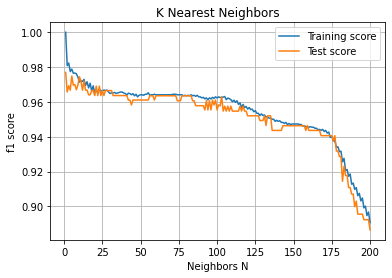

In [21]:
f1_scores_train1, f1_scores_test1, training_times1 = run_knn_stratified(X_train1, y_train1, X_test1, y_test1, figname='ds1_knn_stratified.png')

In [22]:
def knn_learning_curve(X_train, y_train, X_test, y_test, n_neighbors=5, figname=''):
    train_sizes = np.arange(0.1, 1.0, .1)
    train_sizes_abs, knn_train_scores, knn_test_scores, knn_fit_times, knn_score_times = learning_curve(KNeighborsClassifier(n_neighbors=n_neighbors), X_train, y_train, train_sizes=train_sizes, 
                                cv=10, n_jobs=4, scoring='f1', shuffle=True, return_times=True, random_state=random_seed)

    create_curve(x_range=train_sizes, train_scores=knn_train_scores, test_scores=knn_test_scores, train_legend='Training score', test_legend='Test score', 
                 title='KNN Learning curve', x_label='% of Training Samples', y_label='F1 score', figname=figname)
    return train_sizes_abs, knn_train_scores, knn_test_scores, knn_fit_times, knn_score_times

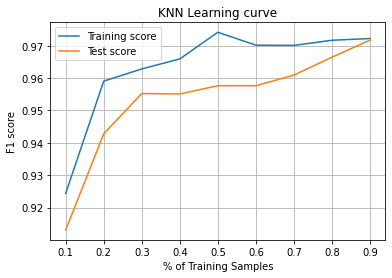

In [23]:
train_sizes_abs1, knn_train_scores1, knn_test_scores1, knn_fit_times1, knn_score_times1 = knn_learning_curve(X_train1, y_train1, X_test1, y_test1, 
                                                                                                             n_neighbors=10, figname='ds1_knn_learning_curve.png')

In [24]:
def knn_validation_curve_n_neighbors(X_train, y_train, X_test, y_test, figname=''):
    n_range = np.arange(1, 51)
    train_scores, test_scores = validation_curve(KNeighborsClassifier(), 
                                X_train, y_train, param_name="n_neighbors", param_range=n_range, cv=5, scoring='f1')

    create_curve(x_range=n_range, train_scores=train_scores, test_scores=test_scores, train_legend='Training score', test_legend='Validation score', 
                 title='KNN Validation curve', x_label='Neighbors N', y_label='F1 score', figname=figname)
    return train_scores, test_scores

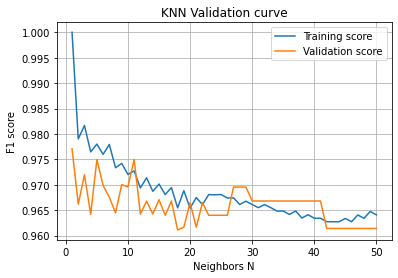

In [25]:
train_scores1, test_scores1 = knn_validation_curve_n_neighbors(X_train1, y_train1, X_test1, y_test1, figname='ds1_knn_vc_n_neighbors.png')

In [26]:
def knn_validation_curve_distance_p(X_train, y_train, X_test, y_test, figname=''):
    p_range = np.arange(1, 5)
    train_scores, test_scores = validation_curve(KNeighborsClassifier(n_neighbors=10, metric='minkowski'), 
                                X_train, y_train, param_name="p", param_range=p_range, cv=5, scoring='f1')

    create_curve(x_range=p_range, train_scores=train_scores, test_scores=test_scores, train_legend='Training score', test_legend='Validation score', 
                 title='KNN Validation curve', x_label='Distance measure p', y_label='F1 score', figname=figname)
    return train_scores, test_scores

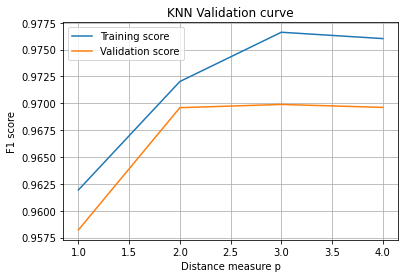

In [27]:
train_scores1, test_scores1 = knn_validation_curve_distance_p(X_train1, y_train1, X_test1, y_test1, figname='ds1_knn_vc_distance_p.png')

## Decision Tree

##### Independent Decision Tree Model

In [28]:
def run_dt_independent(X_train, y_train, X_test, y_test):
    classifier_dt = DecisionTreeClassifier(random_state = random_seed)
    classifier_dt.fit(X_train, y_train)
    y_pred_dt = classifier_dt.predict(X_test)
    print_metrics('Decision Tree', y_test, y_pred_dt)

In [29]:
run_dt_independent(X_train1, y_train1, X_test1, y_test1)

Metrics for classifier: Decision Tree
Confusion Matrix: 
 [[132   0]
 [  1  47]]
Accuracy score 0.9944444444444445
Precision score 1.0
Recall score 0.9791666666666666
ROC AUC score 0.9895833333333333
F1 score 0.9894736842105264


In [30]:
# Decision Tree Hyperparameter tuning using StratifiedKFold
def run_dt_stratified(X_train, y_train, X_test, y_test, figname=''):
    cell_start = time.time()
    max = 50
    param_range = np.arange(1, max + 1)
    f1_scores_train = np.zeros((max+1, 1))
    f1_scores_test = np.zeros((max+1, 1))
    training_times = np.zeros((max+1, 1))

    for index in param_range:
        start = time.time()
        classifier = DecisionTreeClassifier(max_depth=index)

        # Reference: Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 3rd Edition by Aurelien Geron
        skfolds = StratifiedKFold(n_splits=fold_size)
        for train_index, test_index in skfolds.split(X_train, y_train):
            X_train_fold = X_train[train_index]
            y_train_fold = y_train[train_index]
            X_test_fold = X_train[test_index]
            y_test_fold = y_train[test_index]
            sample_count = train_index.shape[0]

            clf = clone(classifier)
            clf.fit(X_train_fold, y_train_fold)
            y_train_pred = clf.predict(X_train_fold)
            y_test_pred = clf.predict(X_test_fold)

            f1_train = f1_score(y_train_fold, y_train_pred) 
            f1_test = f1_score(y_test_fold, y_test_pred)

            f1_scores_train[index] = f1_scores_train[index] + f1_train
            f1_scores_test[index] = f1_scores_test[index] + f1_test

        end =  time.time()
        training_times[index] = end - start
        f1_scores_train[index] = f1_scores_train[index] / fold_size
        f1_scores_test[index] = f1_scores_test[index] / fold_size

    dt_data = {'x_values': param_range,
                'train_scores': f1_scores_train[1:],
                'test_scores': f1_scores_test[1:],
                'train_legend': 'Training score',
                'test_legend': 'Test score',
                'title': 'Stratified KFold: Decision Tree',
                'xlabel': 'Max Depth',
                'ylabel': 'f1 score',
                'figname': figname}

    create_plot(dt_data)

    cell_end = time.time()
    print(f'Time taken to run Stratified KFold on Decision Tree: {cell_end - cell_start}')
    
    return f1_scores_train, f1_scores_test, training_times

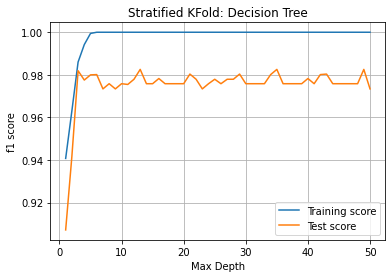

Time taken to run Stratified KFold on Decision Tree: 1.736360788345337


In [31]:
f1_scores_train1, f1_scores_test1, training_times1 = run_dt_stratified(X_train1, y_train1, X_test1, y_test1, figname='ds1_dt_stratified.png')

In [32]:
# Reference: https://github.com/krishnaik06/Post_Pruning_DecisionTre/blob/master/plot_cost_complexity_pruning.ipynb

def run_dt_ccp_alpha(X_train, y_train, X_test, y_test, figname=''):
    clf = DecisionTreeClassifier(random_state=random_seed)
    clf.fit(X_train,y_train)
    pred=clf.predict(X_test)
    f1score = f1_score(y_test, pred)
    print(f'Default f1_score: {f1score}')

    path = clf.cost_complexity_pruning_path(X_train, y_train)
    ccp_alphas, impurities = path.ccp_alphas, path.impurities
    clfs = []
    for ccp_alpha in ccp_alphas:
        clf = DecisionTreeClassifier(random_state=random_seed, ccp_alpha=ccp_alpha)
        clf.fit(X_train, y_train)
        clfs.append(clf)
    print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
          clfs[-1].tree_.node_count, ccp_alphas[-1]))

    train_scores = [clf.score(X_train, y_train) for clf in clfs]
    test_scores = [clf.score(X_test, y_test) for clf in clfs]

    fig, ax = plt.subplots()
    ax.set_xlabel("alpha")
    ax.set_ylabel("f1")
    ax.set_title("Decision Tree ccp_alpha hyperparameter")
    ax.plot(ccp_alphas, train_scores, marker='o', label="train",
            drawstyle="steps-post")
    ax.plot(ccp_alphas, test_scores, marker='o', label="test",
            drawstyle="steps-post")
    ax.legend()
    plt.grid()
    if figname and SAVE_IMAGES:
        plt.savefig(figname)
    plt.show()

Default f1_score: 0.9894736842105264
Number of nodes in the last tree is: 1 with ccp_alpha: 0.33829303000009675


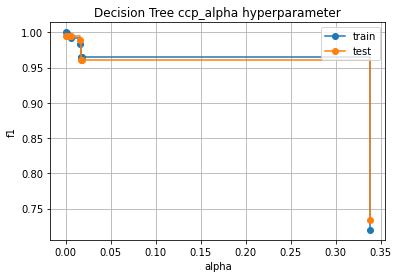

In [33]:
run_dt_ccp_alpha(X_train1, y_train1, X_test1, y_test1, figname='ds1_dt_vc_ccp_alpha.png')

In [34]:
def dt_learning_curve(X_train, y_train, X_test, y_test, max_depth=4, ccp_alpha=0.05, figname=''):
    train_sizes = np.arange(0.1, 1.0, .1)
    train_sizes_abs, dt_train_scores, dt_test_scores, dt_fit_times, dt_score_times = learning_curve(DecisionTreeClassifier(random_state=random_seed, max_depth=max_depth, ccp_alpha=ccp_alpha), 
                    X_train, y_train, train_sizes=train_sizes, cv=10, n_jobs=4, scoring='f1', 
                    shuffle=True, return_times=True, random_state=random_seed)

    create_curve(x_range=train_sizes, train_scores=dt_train_scores, test_scores=dt_test_scores, train_legend='Training score', test_legend='Test score', 
                 title='Decision Tree Learning curve', x_label='% of Training Samples', y_label='F1 score', figname=figname)
    return train_sizes_abs, dt_train_scores, dt_test_scores, dt_fit_times, dt_score_times

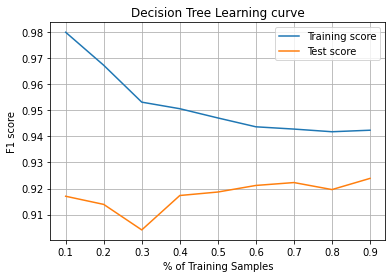

In [35]:
train_sizes_abs1, dt_train_scores1, dt_test_scores1, dt_fit_times1, dt_score_times1 = dt_learning_curve(X_train1, y_train1, X_test1, y_test1, 
                                                                                                        max_depth= 4, ccp_alpha=0.05, figname='ds1_dt_learning_curve.png')

In [36]:
def dt_validtion_curve_max_depth(X_train, y_train, X_test, y_test, figname=''):
    n_range = np.arange(1, 51)
    train_scores, test_scores = validation_curve(DecisionTreeClassifier(), 
                                X_train, y_train, param_name="max_depth", param_range=n_range, cv=5, scoring='f1')

    create_curve(x_range=n_range, train_scores=train_scores, test_scores=test_scores, train_legend='Training score', test_legend='Validation score', 
                 title='Decision Tree Validation curve', x_label='Max Depth', y_label='F1 score', figname=figname)
    return train_scores, test_scores

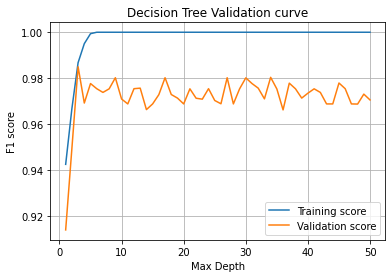

In [37]:
train_scores1, test_scores1 = dt_validtion_curve_max_depth(X_train1, y_train1, X_test1, y_test1, figname='ds1_dt_vc_max_depth.png')

[Text(0.5454545454545454, 0.9166666666666666, 'X[16] <= 0.44\ngini = 0.403\nsamples = 717\nvalue = [516, 201]'),
 Text(0.2727272727272727, 0.75, 'X[20] <= 0.478\ngini = 0.027\nsamples = 505\nvalue = [498, 7]'),
 Text(0.18181818181818182, 0.5833333333333334, 'X[16] <= 0.312\ngini = 0.004\nsamples = 499\nvalue = [498, 1]'),
 Text(0.09090909090909091, 0.4166666666666667, 'gini = 0.0\nsamples = 493\nvalue = [493, 0]'),
 Text(0.2727272727272727, 0.4166666666666667, 'X[16] <= 0.348\ngini = 0.278\nsamples = 6\nvalue = [5, 1]'),
 Text(0.18181818181818182, 0.25, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.36363636363636365, 0.25, 'gini = 0.0\nsamples = 5\nvalue = [5, 0]'),
 Text(0.36363636363636365, 0.5833333333333334, 'gini = 0.0\nsamples = 6\nvalue = [0, 6]'),
 Text(0.8181818181818182, 0.75, 'X[4] <= 0.5\ngini = 0.155\nsamples = 212\nvalue = [18, 194]'),
 Text(0.7272727272727273, 0.5833333333333334, 'X[20] <= 0.486\ngini = 0.495\nsamples = 40\nvalue = [18, 22]'),
 Text(0.6363636363636

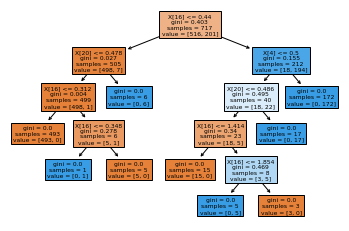

In [38]:
clf = DecisionTreeClassifier(random_state=random_seed, max_depth=10)
clf.fit(X_train1, y_train1)
sklearn.tree.plot_tree(clf,filled=True)

## Boosting

In [39]:
dt = DecisionTreeClassifier(max_depth=5)
ada = AdaBoostClassifier(base_estimator=dt, random_state=random_seed, n_estimators=20)

In [40]:
def run_adaboost_independent(X_train, y_train, X_test, y_test):
    dt = DecisionTreeClassifier(max_depth=5)
    ada = AdaBoostClassifier(base_estimator=dt, random_state=random_seed)
    ada.fit(X_train, y_train)
    y_pred_ada = ada.predict(X_test)
    print_metrics('Boosting', y_test, y_pred_ada)

In [41]:
 run_adaboost_independent(X_train1, y_train1, X_test1, y_test1)

Metrics for classifier: Boosting
Confusion Matrix: 
 [[132   0]
 [  1  47]]
Accuracy score 0.9944444444444445
Precision score 1.0
Recall score 0.9791666666666666
ROC AUC score 0.9895833333333333
F1 score 0.9894736842105264


In [42]:
def run_adaboost_stratified(best_estimator, X_train, y_train, X_test, y_test, figname=''):
    param_max = 50
    param_range = np.arange(1, param_max+1)
    f1_scores_train = np.zeros((param_max+1, 1))
    f1_scores_test = np.zeros((param_max+1, 1))
    ada_training_times = np.zeros((param_max+1, 1))

    for n in param_range:
        start = time.time()
        clasifier = AdaBoostClassifier(base_estimator=best_estimator, n_estimators=n, random_state=random_seed)

        # Reference: Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 3rd Edition by Aurelien Geron
        skfolds = StratifiedKFold(n_splits=fold_size)
        for train_index, test_index in skfolds.split(X_train, y_train):
            X_train_fold = X_train[train_index]
            y_train_fold = y_train[train_index]
            X_test_fold = X_train[test_index]
            y_test_fold = y_train[test_index]
            sample_count = train_index.shape[0]

            clf = clone(clasifier)
            clf.fit(X_train_fold, y_train_fold)
            y_train_pred = clf.predict(X_train_fold)
            y_test_pred = clf.predict(X_test_fold)

            f1_train = f1_score(y_train_fold, y_train_pred) 
            f1_test = f1_score(y_test_fold, y_test_pred)

            f1_scores_train[n] = f1_scores_train[n] + f1_train
            f1_scores_test[n] = f1_scores_test[n] + f1_test

        end =  time.time()
        ada_training_times[n] = end - start
        f1_scores_train[n] = f1_scores_train[n] / fold_size
        f1_scores_test[n] = f1_scores_test[n] / fold_size

    ada_data = {'x_values': param_range, 'train_scores': f1_scores_train[1:], 'test_scores': f1_scores_test[1:], 'train_legend': 'Training score',
                'test_legend': 'Test score', 'title': 'AdaBoost', 'xlabel': 'Number of estimators', 'ylabel': 'f1 score', 'figname': figname}

    create_plot(ada_data)
    return f1_scores_train, f1_scores_test, ada_training_times

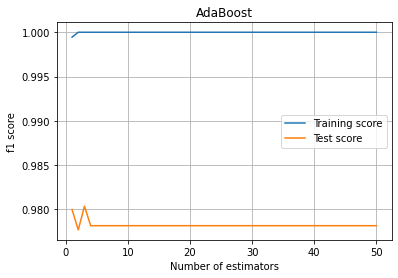

In [43]:
f1_scores_train1, f1_scores_test1, ada_training_times1 = run_adaboost_stratified(dt, X_train1, y_train1, X_test1, y_test1, figname='ds1_ada_stratified.png')

In [44]:
def adaboost_learning_curve(classifier, X_train, y_train, X_test, y_test, figname=''):
    train_sizes = np.arange(0.1, 1.0, .1)
    train_sizes_abs, ada_train_scores, ada_test_scores, ada_fit_times, ada_score_times = learning_curve(classifier, X_train, y_train, train_sizes=train_sizes, 
                                cv=10, n_jobs=4, scoring='f1', shuffle=True, return_times=True, random_state=random_seed)

    create_curve(x_range=train_sizes, train_scores=ada_train_scores, test_scores=ada_test_scores, train_legend='Training score', test_legend='Test score', 
                 title='Adaboost Learning curve', x_label='% of Training Samples', y_label='F1 score', figname=figname)
    return train_sizes_abs, ada_train_scores, ada_test_scores, ada_fit_times, ada_score_times

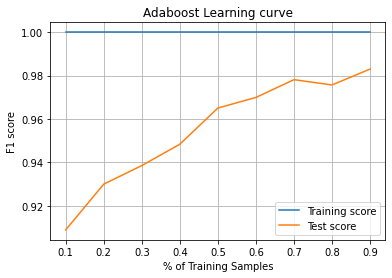

In [45]:
classifier_ada1 = ada
train_sizes_abs1, ada_train_scores1, ada_test_scores1, ada_fit_times1, ada_score_times1 = adaboost_learning_curve(
    classifier_ada1, X_train1, y_train1, X_test1, y_test1, figname='ds1_ada_learning_curve.png')

In [46]:
def adaboost_validation_curve_n_estimators(X_train, y_train, X_test, y_test, figname=''):
    n_estimators = np.arange(1, 51)
    train_scores, test_scores = validation_curve(AdaBoostClassifier(base_estimator=dt, random_state=random_seed), 
                                X_train, y_train, param_name="n_estimators", param_range=n_estimators, cv=5, scoring='f1')

    create_curve(x_range=n_estimators, train_scores=train_scores, test_scores=test_scores, train_legend='Training score', test_legend='Validation score', 
                 title='Adaboost Validation curve', x_label='Number of estimators', y_label='F1 score', figname=figname)
    return train_scores, test_scores

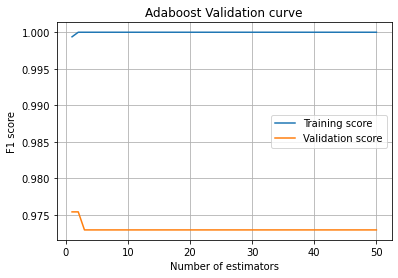

In [47]:
train_scores1, test_scores1 = adaboost_validation_curve_n_estimators(X_train1, y_train1, X_test1, y_test1, figname='ds1_ada_vc_n_estimators.png')

In [48]:
def adaboost_validation_curve_learning_rate(X_train, y_train, X_test, y_test, figname=''):
    learning_rate_range = np.arange(1, 10)
    train_scores, test_scores = validation_curve(AdaBoostClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.05), random_state=random_seed), 
                                X_train, y_train, param_name="learning_rate", param_range=learning_rate_range, cv=5, scoring='f1')

    create_curve(x_range=learning_rate_range, train_scores=train_scores, test_scores=test_scores, train_legend='Training score', test_legend='Validation score', 
                 title='Adaboost Validation curve', x_label='Learning Rate', y_label='F1 score', figname=figname)
    return train_scores, test_scores

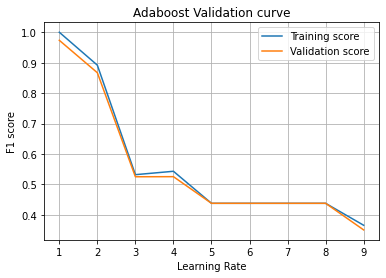

In [49]:
train_scores1, test_scores1 = adaboost_validation_curve_learning_rate(X_train1, y_train1, X_test1, y_test1, figname='ds1_ada_vc_learning_rate.png')

## Support Vector Machines

In [50]:
def run_svm_independent(X_train, y_train, X_test, y_test):
    classifier_svm = SVC(kernel = 'rbf', random_state = random_seed)
    classifier_svm.fit(X_train, y_train)
    y_pred_svm = classifier_svm.predict(X_test)
    print_metrics('SVM', y_test, y_pred_svm)

In [51]:
run_svm_independent(X_train1, y_train1, X_test1, y_test1)

Metrics for classifier: SVM
Confusion Matrix: 
 [[131   1]
 [  0  48]]
Accuracy score 0.9944444444444445
Precision score 0.9795918367346939
Recall score 1.0
ROC AUC score 0.9962121212121212
F1 score 0.9896907216494846


In [52]:
classifier_svm = SVC(kernel = 'rbf', random_state = random_seed)

scores = cross_val_score(classifier_svm, X_train1, y_train1, scoring='f1', cv=5, n_jobs=4, 
                verbose=1, pre_dispatch='2*n_jobs')
print(scores)

results = cross_validate(classifier_svm, X_train1, y_train1, scoring='f1', cv=10, n_jobs=4, 
                verbose=10, pre_dispatch='2*n_jobs', return_train_score=True)
results

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


[0.96202532 0.95238095 1.         0.975      1.        ]


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Batch computation too fast (0.0160s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


{'fit_time': array([0.0029974 , 0.00399756, 0.00399923, 0.00299978, 0.00400066,
        0.0040009 , 0.00299716, 0.00399804, 0.00300074, 0.00300026]),
 'score_time': array([0.00100017, 0.00300002, 0.00200057, 0.00200081, 0.00100303,
        0.00200081, 0.00102425, 0.00100088, 0.00199938, 0.00199866]),
 'test_score': array([0.97435897, 0.95      , 0.92682927, 0.97560976, 1.        ,
        1.        , 0.97674419, 0.97435897, 1.        , 1.        ]),
 'train_score': array([0.99444444, 0.99447514, 0.99168975, 0.98888889, 0.98895028,
        0.98888889, 0.99159664, 0.98607242, 0.98888889, 0.98888889])}

In [53]:
def svm_learning_curve(X_train, y_train, X_test, y_test, figname=''):
    train_sizes = np.arange(0.1, 1.0, .1)
    train_sizes_abs, svm_train_scores, svm_test_scores, svm_fit_times, svm_score_times = learning_curve(classifier_svm, X_train, y_train, train_sizes=train_sizes, 
                                cv=10, n_jobs=4, scoring='f1', shuffle=True, return_times=True, random_state=random_seed)

    create_curve(x_range=train_sizes, train_scores=svm_train_scores, test_scores=svm_test_scores, train_legend='Training score', test_legend='Test score', 
                 title='SVM Learning curve', x_label='% of Training Samples', y_label='F1 score', figname=figname)
    return train_sizes_abs, svm_train_scores, svm_test_scores, svm_fit_times, svm_score_times

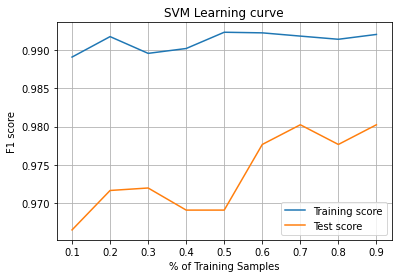

In [54]:
train_sizes_abs1, svm_train_scores1, svm_test_scores1, svm_fit_times1, svm_score_times1 = svm_learning_curve(
    X_train1, y_train1, X_test1, y_test1, figname='ds1_svm_learning_curve.png')

In [55]:
def svm_validation_curve_gamma(X_train, y_train, X_test, y_test, figname=''):
    param_range = np.logspace(-6, -1, 5)
    train_scores, test_scores = validation_curve(SVC(), 
                                X_train, y_train, param_name="gamma", param_range=param_range, cv=5, scoring='f1')

    create_curve(x_range=param_range, train_scores=train_scores, test_scores=test_scores, train_legend='Training score', test_legend='Validation score', 
                 title='SVM Validation curve', x_label='gamma', y_label='F1 score', figname=figname)
    return train_scores, test_scores

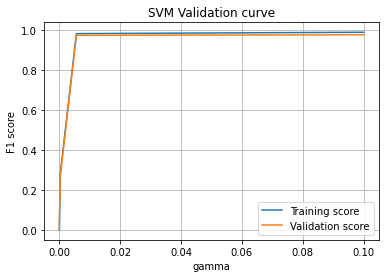

In [56]:
train_scores1, test_scores1 = svm_validation_curve_gamma(X_train1, y_train1, X_test1, y_test1, figname='ds1_svm_vc_gamma.png')

In [57]:
def svm_validation_curve_kernel(X_train, y_train, X_test, y_test, figname=''):
    kernels = ['linear', 'sigmoid', 'rbf']
    train_scores, test_scores = validation_curve(SVC(), 
                                X_train, y_train, param_name="kernel", param_range=kernels, cv=5, scoring='f1')

    create_curve(x_range=kernels, train_scores=train_scores, test_scores=test_scores, train_legend='Training score', test_legend='Validation score', 
                 title='SVM Validation curve', x_label='Kernel', y_label='F1 score', figname=figname)
    return train_scores, test_scores

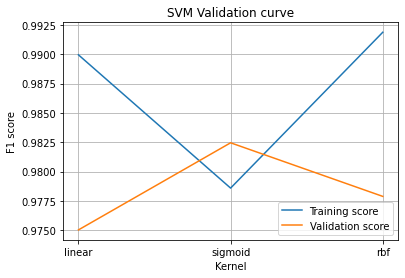

In [58]:
train_scores1, test_scores1 = svm_validation_curve_kernel(X_train1, y_train1, X_test1, y_test1, figname='ds1_svm_vc_kernel.png')

### Neural Network

In [59]:
def run_nn_independent(X_train, y_train, X_test, y_test):
    clf_nn = MLPClassifier(hidden_layer_sizes=(20, ), random_state=random_seed, max_iter=1000)
    clf_nn.fit(X_train, y_train)
    y_pred = clf_nn.predict(X_test)
    print_metrics('Neural Networks', y_test, y_pred)

In [60]:
run_nn_independent(X_train1, y_train1, X_test1, y_test1)

Metrics for classifier: Neural Networks
Confusion Matrix: 
 [[131   1]
 [  0  48]]
Accuracy score 0.9944444444444445
Precision score 0.9795918367346939
Recall score 1.0
ROC AUC score 0.9962121212121212
F1 score 0.9896907216494846


In [61]:
def nn_validation_curve_hidden_layers(X_train, y_train, X_test, y_test):
    if DATASET_ID == DATASET_1:
        figname1 = 'ds1_nn_vc_1_layer.png'
        figname2 = 'ds1_nn_vc_2_layer.png'
    else:
        figname1 = 'ds2_nn_vc_1_layer.png'
        figname2 = 'ds2_nn_vc_2_layer.png'
    
    inputs = X_train.shape[1]
    layer_size_range = np.arange(1, 2*inputs)

    one_layer_hidden_layer_sizes_range = [(i, ) for i in layer_size_range]
    train_scores, test_scores = validation_curve(MLPClassifier(random_state=random_seed, max_iter=1000), X_train, y_train, 
                                                 param_name="hidden_layer_sizes", param_range=one_layer_hidden_layer_sizes_range, cv=5, n_jobs=4, scoring='f1')

    create_curve(x_range=layer_size_range, train_scores=train_scores, test_scores=test_scores, train_legend='Training score', test_legend='Validation score', 
                 title='Neural Networks Validation curve', x_label='1 layer model', y_label='F1 score', figname=figname1)


    two_layer_hidden_layer_sizes_range = [(i, i) for i in layer_size_range]
    train_scores, test_scores = validation_curve(MLPClassifier(random_state=random_seed, max_iter=1000), X_train, y_train, 
                                                 param_name="hidden_layer_sizes", param_range=two_layer_hidden_layer_sizes_range, cv=5, n_jobs=4, scoring='f1')

    create_curve(x_range=layer_size_range, train_scores=train_scores, test_scores=test_scores, train_legend='Training score', test_legend='Validation score', 
                 title='Neural Networks Validation curve', x_label='2 layer model', y_label='F1 score', figname=figname2)

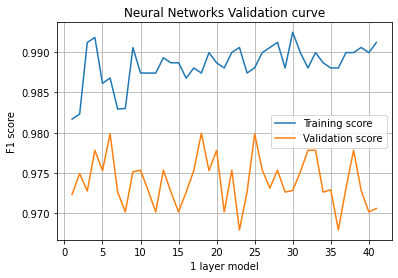

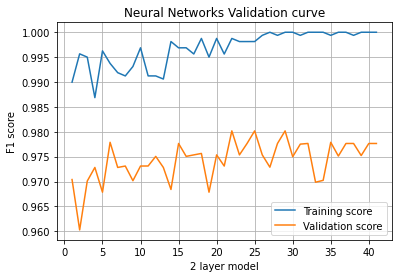

In [62]:
nn_validation_curve_hidden_layers(X_train1, y_train1, X_test1, y_test1)

In [63]:
def nn_learning_curve(X_train, y_train, X_test, y_test, figname=''):
    train_sizes = np.arange(0.1, 1.0, .1)
    train_sizes_abs, nn_train_scores, nn_test_scores, nn_fit_times, nn_score_times = learning_curve(classifier_svm, X_train, y_train, train_sizes=train_sizes, 
                                cv=10, n_jobs=4, scoring='f1', shuffle=True, return_times=True, random_state=random_seed)

    create_curve(x_range=train_sizes, train_scores=nn_train_scores, test_scores=nn_test_scores, train_legend='Training score', test_legend='Test score', 
                 title='Neural Networks Learning curve', x_label='% of Training Samples', y_label='F1 score', figname=figname)
    return train_sizes_abs, nn_train_scores, nn_test_scores, nn_fit_times, nn_score_times

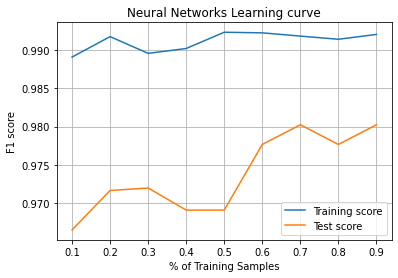

In [64]:
train_sizes_abs1, nn_train_scores1, nn_test_scores1, nn_fit_times1, nn_score_times1 = nn_learning_curve(
    X_train1, y_train1, X_test1, y_test1, figname='ds1_nn_learning_curve.png')

In [65]:
def nn_validation_curve_learning_rate_init(X_train, y_train, X_test, y_test, figname=''):
    param_range = np.arange(0.0001, 1, .1)
    param_range = np.logspace(-3, 3, 6)
    train_scores, test_scores = validation_curve(MLPClassifier(), 
                                X_train, y_train, param_name="learning_rate_init", param_range=param_range, cv=5, scoring='f1')

    create_log_curve(x_range=param_range, train_scores=train_scores, test_scores=test_scores, train_legend='Training score', test_legend='Validation score', 
                 title='Neural Networks Validation curve', x_label='learning rate init', y_label='F1 score', figname=figname)
    return train_scores, test_scores

C:\Users\yogpaul\work\sw\Anaconda3\envs\py38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\yogpaul\work\sw\Anaconda3\envs\py38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


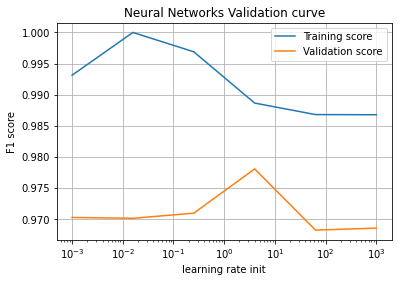

In [66]:
train_scores1, test_scores1 = nn_validation_curve_learning_rate_init(X_train1, y_train1, X_test1, y_test1, figname='ds1_nn_vc_learning_rate_init.png')

In [67]:
def nn_loss_curve(X_train, y_train, X_test, y_test, hidden_layer_sizes=(100,), learning_rate_init=0.001, figname=''):
    nn = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, learning_rate_init=learning_rate_init, random_state=random_seed)
    nn.fit(X_train, y_train)
    loss = nn.loss_curve_
    
    create_loss_curve(scores=loss, legend='NN Loss', title='Neural Networks loss v/s iterations', x_label='Iterations', y_label='loss', figname=figname)

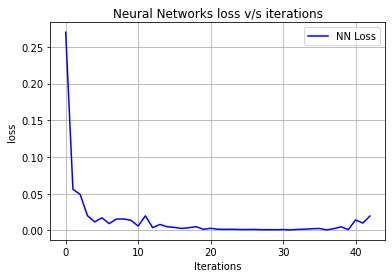

In [68]:
nn_loss_curve(X_train1, y_train1, X_test1, y_test1, hidden_layer_sizes=(50,), learning_rate_init=0.1, figname='ds1_nn_loss_curve.png')

### Model Performance

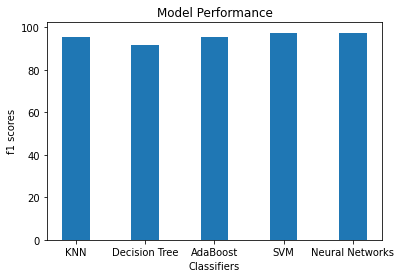

In [69]:
knn_mean1 = get_mean_score(knn_test_scores1)
dt_mean1 = get_mean_score(dt_test_scores1)
ada_mean1 = get_mean_score(ada_test_scores1)
svm_mean1 = get_mean_score(svm_test_scores1)
nn_mean1 = get_mean_score(nn_test_scores1)

create_model_comparison(knn_mean1, dt_mean1, ada_mean1, svm_mean1, nn_mean1, figname='ds1_model_comparison.png')

### Time comparison

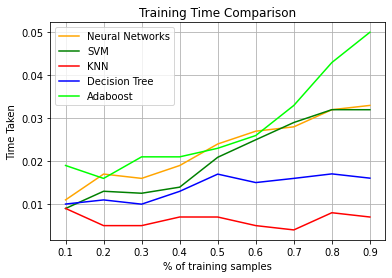

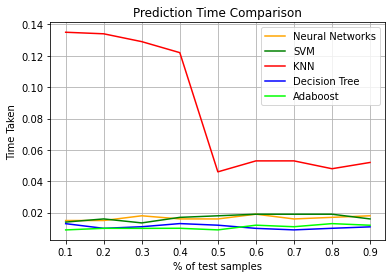

In [70]:
x_range = np.arange(0.1, 1.0, .1)

create_time_plot("Training Time Comparison", "% of training samples", "Time Taken", knn_fit_times1, 
                 dt_fit_times1, ada_fit_times1, svm_fit_times1, nn_fit_times1, figname='ds1_timeplot_training.png')

create_time_plot("Prediction Time Comparison", "% of test samples", "Time Taken", knn_score_times1, 
                 dt_score_times1, ada_score_times1, svm_score_times1, nn_score_times1, figname='ds1_timeplot_predict.png')

## Dataset 2 Credit Card customers (Predict Churning customers)
Source: https://www.kaggle.com/datasets/sakshigoyal7/credit-card-customers

In [71]:
DATASET_ID = DATASET_2
RESAMPLING_TECHNIQUE = USE_UNDERSAMPLING_CNN

In [72]:
data2 = getData(DATASET_ID)

print(f'Shape of data: {data2.shape}')

data2 = data2.rename(columns={
    'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1': 'Naive_bayes_mon_1', 
    'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2': 'Naive_bayes_mon_2'})

data2 = data2.drop(['Naive_bayes_mon_1', 'Naive_bayes_mon_2'], axis = 1)

data2.head()

Shape of data: (10127, 22)


,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [73]:
print(data2["Attrition_Flag"].value_counts())
print(data2["Attrition_Flag"].value_counts()/len(data2))
data2.describe()

Existing Customer    8500
Attrited Customer    1627
Name: Attrition_Flag, dtype: int64
Existing Customer    0.83934
Attrited Customer    0.16066
Name: Attrition_Flag, dtype: float64


,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


In [74]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

In [75]:
data2.corr()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
Customer_Age,1.000000,-0.122254,0.788912,-0.010931,0.054361,-0.018452,0.002476,0.014780,0.001151,-0.062042,-0.046446,-0.067097,-0.012143,0.007114
Dependent_count,-0.122254,1.000000,-0.103062,-0.039076,-0.010768,-0.040505,0.068065,-0.002688,0.068291,-0.035439,0.025046,0.049912,0.011087,-0.037135
Months_on_book,0.788912,-0.103062,1.000000,-0.009203,0.074164,-0.010774,0.007507,0.008623,0.006732,-0.048959,-0.038591,-0.049819,-0.014072,-0.007541
Total_Relationship_Count,-0.010931,-0.039076,-0.009203,1.000000,-0.003675,0.055203,-0.071386,0.013726,-0.072601,0.050119,-0.347229,-0.241891,0.040831,0.067663
Months_Inactive_12_mon,0.054361,-0.010768,0.074164,-0.003675,1.000000,0.029493,-0.020394,-0.042210,-0.016605,-0.032247,-0.036982,-0.042787,-0.038989,-0.007503
Contacts_Count_12_mon,-0.018452,-0.040505,-0.010774,0.055203,0.029493,1.000000,0.020817,-0.053913,0.025646,-0.024445,-0.112774,-0.152213,-0.094997,-0.055471
Credit_Limit,0.002476,0.068065,0.007507,-0.071386,-0.020394,0.020817,1.000000,0.042493,0.995981,0.012813,0.171730,0.075927,-0.002020,-0.482965
Total_Revolving_Bal,0.014780,-0.002688,0.008623,0.013726,-0.042210,-0.053913,0.042493,1.000000,-0.047167,0.058174,0.064370,0.056060,0.089861,0.624022
Avg_Open_To_Buy,0.001151,0.068291,0.006732,-0.072601,-0.016605,0.025646,0.995981,-0.047167,1.000000,0.007595,0.165923,0.070885,-0.010076,-0.538808
Total_Amt_Chng_Q4_Q1,-0.062042,-0.035439,-0.048959,0.050119,-0.032247,-0.024445,0.012813,0.058174,0.007595,1.000000,0.039678,0.005469,0.384189,0.035235


### Data Preprocessing

In [76]:
X2 = data2.iloc[:, 1:].values
y2 = data2.iloc[:, 0].values

print(f'Shape of X2: {X2.shape}')
print(f'Shape of y2: {y2.shape}')

Shape of X2: (10127, 19)
Shape of y2: (10127,)


#### Encode categorical independent variables

In [77]:
print(data2.columns)
cols_to_encode2 = ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']
# skipping OneHotEncoding of binary features based on following explanation: https://stackoverflow.com/a/64377627
col_indices2 = [(data2.columns.get_loc(col)-1) for col in cols_to_encode2]
col_indices2

Index(['Attrition_Flag', 'Customer_Age', 'Gender', 'Dependent_count',
       'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category',
       'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')


[1, 3, 4, 5, 6]

In [78]:
X2 = do_column_one_hot_encoding(X2, col_indices2)

First row of X after imputation and encoding: [0.0 1.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0
 0.0 1.0 0.0 0.0 0.0 45 3 39 5 1 3 12691.0 777 11914.0 1.335 1144 42 1.625
 0.061]
['encoder__x1_F' 'encoder__x1_M' 'encoder__x3_College'
 'encoder__x3_Doctorate' 'encoder__x3_Graduate' 'encoder__x3_High School'
 'encoder__x3_Post-Graduate' 'encoder__x3_Uneducated'
 'encoder__x3_Unknown' 'encoder__x4_Divorced' 'encoder__x4_Married'
 'encoder__x4_Single' 'encoder__x4_Unknown' 'encoder__x5_$120K +'
 'encoder__x5_$40K - $60K' 'encoder__x5_$60K - $80K'
 'encoder__x5_$80K - $120K' 'encoder__x5_Less than $40K'
 'encoder__x5_Unknown' 'encoder__x6_Blue' 'encoder__x6_Gold'
 'encoder__x6_Platinum' 'encoder__x6_Silver' 'remainder__x0'
 'remainder__x2' 'remainder__x7' 'remainder__x8' 'remainder__x9'
 'remainder__x10' 'remainder__x11' 'remainder__x12' 'remainder__x13'
 'remainder__x14' 'remainder__x15' 'remainder__x16' 'remainder__x17'
 'remainder__x18']


##### Encoding the Dependent Variable

In [79]:
le = LabelEncoder()
y2 = le.fit_transform(y2)

##### Resampling for imbalanced datasets

In [80]:
X_resampled2, y_resampled2 = do_resampling(X2, y2)

After resampling with USE_UNDERSAMPLING_CNN: Shape of X: (2959, 37), Shape of y: (2959,)
After resampling: value counts: [0 1] : [1627 1332]
[1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00
 0.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 6.2000e+01
 0.0000e+00 4.9000e+01 2.0000e+00 3.0000e+00 3.0000e+00 1.4383e+03
 0.0000e+00 1.4383e+03 1.0470e+00 6.9200e+02 1.6000e+01 6.0000e-01
 0.0000e+00]


##### Split training and test set

In [81]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_resampled2, y_resampled2, test_size = 0.2, random_state = 1)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

print(X_train2.shape, X_test2.shape, y_train2.shape, y_test2.shape)

(2367, 37) (592, 37) (2367,) (592,)


##### Feature Scaling

In [82]:
columns_to_scale2 = [index for index in range(24, 37)]
columns_to_scale2

[24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]

In [83]:
X_train2, X_test2 = do_feature_scaling(X_train2, X_test2, columns_to_scale2)

### KNN

In [84]:
run_knn_independent(X_train2, y_train2, X_test2, y_test2)

Metrics for classifier: KNN
Confusion Matrix: 
 [[270  64]
 [ 67 191]]
Accuracy score 0.7787162162162162
Precision score 0.7490196078431373
Recall score 0.7403100775193798
ROC AUC score 0.774346655526157
F1 score 0.7446393762183235


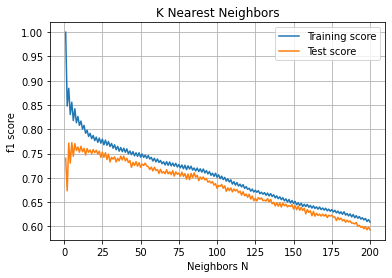

In [85]:
f1_scores_train2, f1_scores_test2, training_times2 = run_knn_stratified(X_train2, y_train2, X_test2, y_test2, figname='ds2_knn_stratified.png')

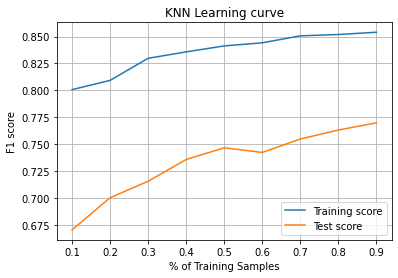

In [86]:
train_sizes_abs2, knn_train_scores2, knn_test_scores2, knn_fit_times2, knn_score_times2 = knn_learning_curve(X_train2, y_train2, X_test2, y_test2, 
                                                                                                             n_neighbors=5, figname='ds2_knn_learning_curve.png')

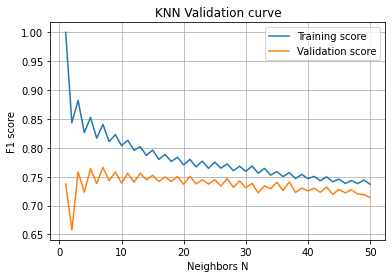

In [87]:
train_scores2, test_scores2 = knn_validation_curve_n_neighbors(X_train2, y_train2, X_test2, y_test2, figname='ds2_knn_vc_n_neighbors.png')

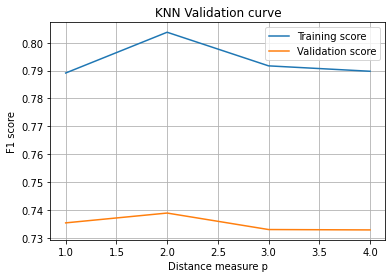

In [88]:
train_scores2, test_scores2 = knn_validation_curve_distance_p(X_train2, y_train2, X_test2, y_test2, figname='ds2_knn_vc_distance_p.png')

### Decision Trees

In [89]:
def run_dt_independent2(X_train, y_train, X_test, y_test):
    classifier_dt = DecisionTreeClassifier(random_state = random_seed)
    classifier_dt.fit(X_train, y_train)
    y_pred_dt = classifier_dt.predict(X_test)
    print_metrics('Decision Tree', y_test, y_pred_dt)
    
run_dt_independent2(X_train2, y_train2, X_test2, y_test2)

Metrics for classifier: Decision Tree
Confusion Matrix: 
 [[294  40]
 [ 30 228]]
Accuracy score 0.8817567567567568
Precision score 0.8507462686567164
Recall score 0.8837209302325582
ROC AUC score 0.881980225595321
F1 score 0.8669201520912547


In [90]:
param_grid = {'ccp_alpha': [0.1, .01, .001],
              'max_depth' : [1, 2, 3, 4, 5, 6, 7, 8, 9],
              'criterion' :['gini', 'entropy']
             }
grid_search = GridSearchCV(DecisionTreeClassifier(random_state = random_seed), param_grid, scoring='f1', n_jobs=4, refit=True, 
                              cv=10, verbose=1, pre_dispatch='2*n_jobs', return_train_score=True)
grid_search.fit(X_train2, y_train2)
grid_search.best_params_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


{'ccp_alpha': 0.001, 'criterion': 'gini', 'max_depth': 9}

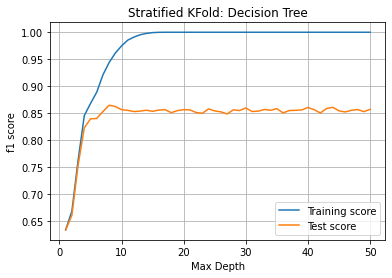

Time taken to run Stratified KFold on Decision Tree: 8.28146481513977


In [91]:
f1_scores_train2, f1_scores_test2, training_times2 = run_dt_stratified(X_train2, y_train2, X_test2, y_test2, figname='ds2_dt_stratified.png')

Default f1_score: 0.8669201520912547
Number of nodes in the last tree is: 1 with ccp_alpha: 0.07552520945236363


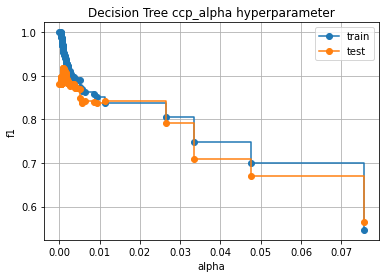

In [92]:
run_dt_ccp_alpha(X_train2, y_train2, X_test2, y_test2, figname='ds2_dt_vc_ccp_alpha.png')

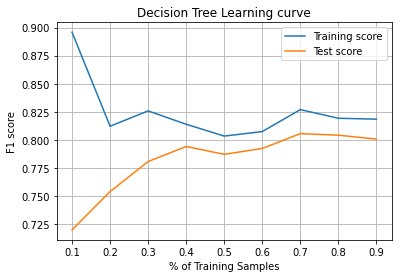

In [93]:
train_sizes_abs2, dt_train_scores2, dt_test_scores2, dt_fit_times2, dt_score_times2 = dt_learning_curve(X_train2, y_train2, X_test2, y_test2, 
                                                                                                        max_depth= 9, ccp_alpha=0.015, figname='ds2_dt_learning_curve.png')

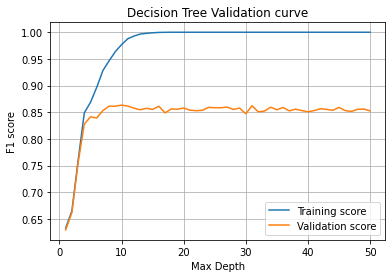

In [94]:
train_scores, test_scores = dt_validtion_curve_max_depth(X_train2, y_train2, X_test2, y_test2, figname='ds2_dt_vc_max_depth.png')

[Text(0.5904091282894737, 0.95, 'X[34] <= 0.159\ngini = 0.496\nsamples = 2367\nvalue = [1293, 1074]'),
 Text(0.4147820723684211, 0.85, 'X[32] <= 1.064\ngini = 0.425\nsamples = 1500\nvalue = [1041, 459]'),
 Text(0.29666940789473684, 0.75, 'X[33] <= -0.5\ngini = 0.373\nsamples = 1376\nvalue = [1035, 341]'),
 Text(0.16817434210526316, 0.65, 'X[26] <= -0.09\ngini = 0.479\nsamples = 695\nvalue = [419, 276]'),
 Text(0.09292763157894737, 0.55, 'X[35] <= 0.572\ngini = 0.315\nsamples = 367\nvalue = [295, 72]'),
 Text(0.047697368421052634, 0.45, 'X[27] <= -1.035\ngini = 0.247\nsamples = 325\nvalue = [278, 47]'),
 Text(0.019736842105263157, 0.35, 'X[33] <= -0.975\ngini = 0.494\nsamples = 38\nvalue = [21, 17]'),
 Text(0.013157894736842105, 0.25, 'gini = 0.0\nsamples = 9\nvalue = [9, 0]'),
 Text(0.02631578947368421, 0.25, 'X[32] <= -0.713\ngini = 0.485\nsamples = 29\nvalue = [12, 17]'),
 Text(0.013157894736842105, 0.15, 'X[34] <= -1.223\ngini = 0.245\nsamples = 7\nvalue = [6, 1]'),
 Text(0.00657894

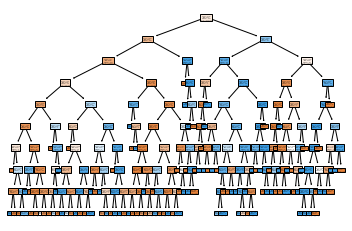

In [95]:
clf = DecisionTreeClassifier(random_state=random_seed, max_depth=9)
clf.fit(X_train2, y_train2)
sklearn.tree.plot_tree(clf,filled=True)

### Boosting

In [96]:
ada_dt2 = DecisionTreeClassifier(random_state=random_seed, max_depth=9, ccp_alpha=0.001)

In [97]:
run_adaboost_independent(X_train2, y_train2, X_test2, y_test2)

Metrics for classifier: Boosting
Confusion Matrix: 
 [[316  18]
 [ 31 227]]
Accuracy score 0.9172297297297297
Precision score 0.926530612244898
Recall score 0.8798449612403101
ROC AUC score 0.912976372835724
F1 score 0.9025844930417495


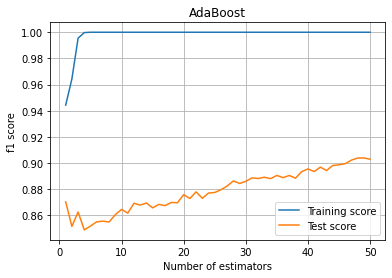

In [98]:
f1_scores_train2, f1_scores_test2, ada_training_times2 = run_adaboost_stratified(ada_dt2, X_train2, y_train2, X_test2, y_test2, figname='ds2_ada_stratified.png')

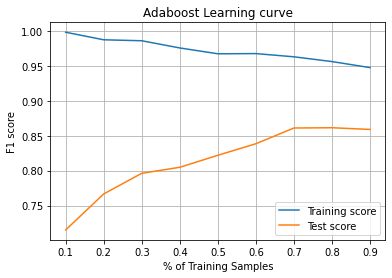

In [99]:
ada2 = AdaBoostClassifier(base_estimator=ada_dt2, random_state=random_seed, n_estimators=20)
train_sizes_abs2, ada_train_scores2, ada_test_scores2, ada_fit_times2, ada_score_times2 = adaboost_learning_curve(
    ada_dt2, X_train2, y_train2, X_test2, y_test2, figname='ds2_ada_learning_curve.png')

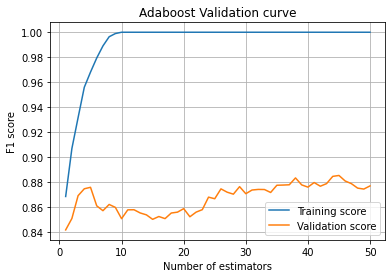

In [100]:
train_scores2, test_scores2 = adaboost_validation_curve_n_estimators(X_train2, y_train2, X_test2, y_test2, figname='ds2_ada_vc_n_estimators.png')

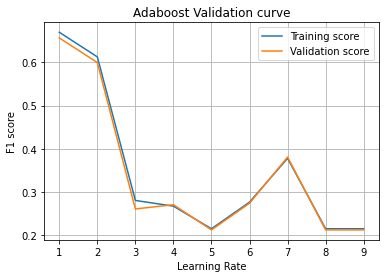

In [101]:
train_scores2, test_scores2 = adaboost_validation_curve_learning_rate(X_train2, y_train2, X_test2, y_test2, figname='ds2_ada_vc_learning_rate.png')

### Support Vector Machines

In [102]:
run_svm_independent(X_train2, y_train2, X_test2, y_test2)

Metrics for classifier: SVM
Confusion Matrix: 
 [[270  64]
 [ 51 207]]
Accuracy score 0.8057432432432432
Precision score 0.7638376383763837
Recall score 0.8023255813953488
ROC AUC score 0.8053544074641416
F1 score 0.7826086956521738


In [103]:
classifier_svm = SVC(kernel = 'rbf', random_state = random_seed)

scores = cross_val_score(classifier_svm, X_train2, y_train2, scoring='f1', cv=5, n_jobs=4, 
                verbose=1, pre_dispatch='2*n_jobs')
print(scores)

results = cross_validate(classifier_svm, X_train2, y_train2, scoring='f1', cv=10, n_jobs=4, 
                verbose=10, pre_dispatch='2*n_jobs', return_train_score=True)
results

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.4s finished


[0.77142857 0.78177458 0.73658537 0.77722772 0.76777251]


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed:    1.4s remaining:    1.4s
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    1.5s remaining:    0.6s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    2.2s finished


{'fit_time': array([0.2160008 , 0.21492362, 0.22500038, 0.19099903, 0.21099901,
        0.2260015 , 0.19199777, 0.23799849, 0.23001647, 0.23000026]),
 'score_time': array([0.04600072, 0.04899597, 0.043998  , 0.05400276, 0.05599976,
        0.07799745, 0.05199981, 0.06099844, 0.05598545, 0.05800104]),
 'test_score': array([0.76056338, 0.78431373, 0.79207921, 0.78378378, 0.75829384,
        0.74038462, 0.78640777, 0.78817734, 0.75247525, 0.77272727]),
 'train_score': array([0.77783697, 0.77860169, 0.77470776, 0.77557579, 0.77700905,
        0.78514589, 0.77613516, 0.776072  , 0.77860169, 0.78201058])}

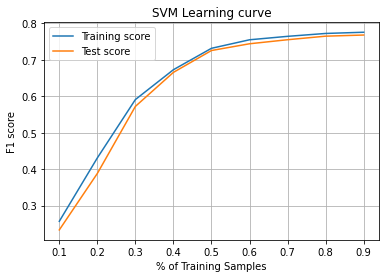

In [104]:
train_sizes_abs2, svm_train_scores2, svm_test_scores2, svm_fit_times2, svm_score_times2 = svm_learning_curve(
    X_train2, y_train2, X_test2, y_test2, figname='ds2_svm_learning_curve.png')

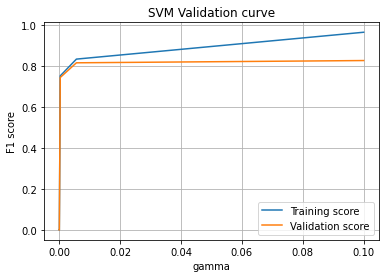

In [105]:
train_scores2, test_scores2 = svm_validation_curve_gamma(X_train2, y_train2, X_test2, y_test2, figname='ds2_svm_vc_gamma.png')

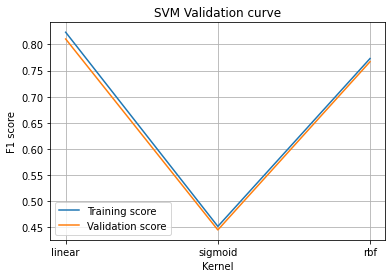

In [106]:
train_scores2, test_scores2 = svm_validation_curve_kernel(X_train2, y_train2, X_test2, y_test2, figname='ds2_svm_vc_kernel.png')

### Neural Networks

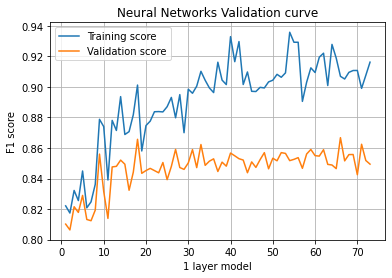

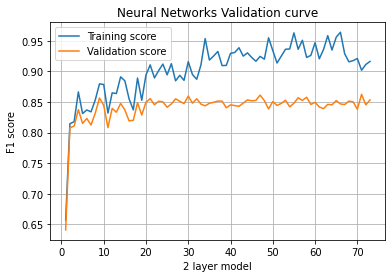

In [107]:
nn_validation_curve_hidden_layers(X_train2, y_train2, X_test2, y_test2)

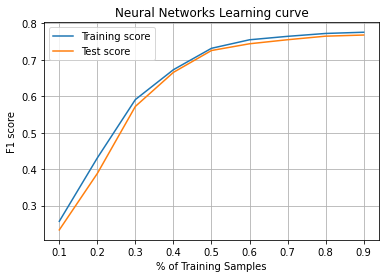

In [108]:
train_sizes_abs2, nn_train_scores2, nn_test_scores2, nn_fit_times2, nn_score_times2 = nn_learning_curve(X_train2, y_train2, X_test2, y_test2, figname='ds2_nn_learning_curve.png')

C:\Users\yogpaul\work\sw\Anaconda3\envs\py38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\yogpaul\work\sw\Anaconda3\envs\py38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\yogpaul\work\sw\Anaconda3\envs\py38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\yogpaul\work\sw\Anaconda3\envs\py38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warning

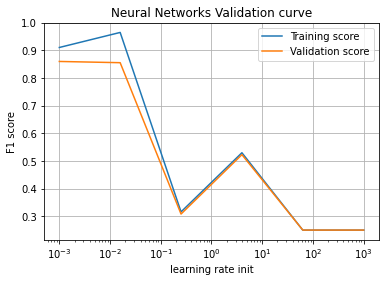

In [109]:
train_scores2, test_scores2 = nn_validation_curve_learning_rate_init(X_train2, y_train2, X_test2, y_test2, figname='ds2_nn_vc_learning_rate_init.png')

C:\Users\yogpaul\work\sw\Anaconda3\envs\py38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


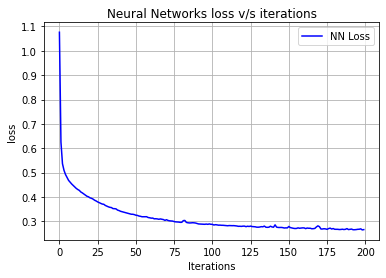

In [110]:
nn_loss_curve(X_train2, y_train2, X_test2, y_test2, hidden_layer_sizes=(50,), learning_rate_init=0.001, figname='ds2_nn_loss_curve.png')

### Model performance

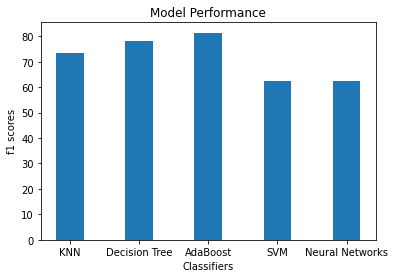

In [112]:
knn_mean2 = get_mean_score(knn_test_scores2)
dt_mean2 = get_mean_score(dt_test_scores2)
ada_mean2 = get_mean_score(ada_test_scores2)
svm_mean2 = get_mean_score(svm_test_scores2)
nn_mean2 = get_mean_score(nn_test_scores2)

create_model_comparison(knn_mean2, dt_mean2, ada_mean2, svm_mean2, nn_mean2, figname='ds2_model_comparison.png')